<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/%EA%B8%88%EC%9C%B5%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D_221217.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Part 4. 금융시장 데이터 수집부터 예측까지 적용해보기</b>

## 실습 가이드
1. 데이터를 다운로드하여 Colab에 불러옵니다.
2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
3. 코드는 위에서부터 아래로 순서대로 실행합니다.
4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## Ch 1. 데이터 수집하기
- 자본시장 시계열 소개
- 파이썬 시계열 분석 패키지 설명
- 수집한 시장 데이터의 전처리 및 시계열 처리


## Ch 2. 자본시장 데이터 이용한 시장 예측해 보기
- Auto ARIMA를 이용하여 시장 예측하기
- Kalman-Filter를 이용하여 시장 예측하기
- 데이터 설명과 전처리
- 결과 해석


## Ch 3. 자본시장 데이터와 추가 변수를 이용한 시장 예측해 보기
- ARCH, GARCH 등 변동성 모형에 대하여 이해하기
- VAR 모형 등 다변량 모형 이용하여 경제지표 예측하기
- 결과 해석, 학습 결과의 비교

## <b> Ch 1. 학습목표 </b>
- 1) 데이터 수집 방법의 이해
- 2) 시계열 예측 모델링 구현 방법 습득
- 3) 모델별 가정의 차이 이해
- 4) 시계열 모델링 결과물의 해석
- 5) 시계열 예측 결과의 모델별 비교

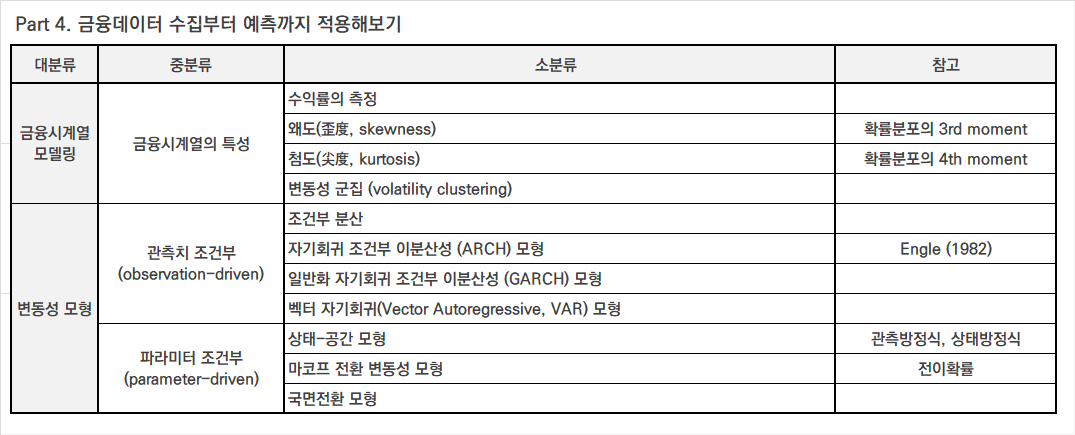

## <b> Ch 2. 데이터 수집하기 </b>

### 자본시장 시계열 소개
<b> 1. </b> 가격 시계열 vs <b>수익률 시계열</b> 

- scale-free
- stationary (<- random walk)
- distributional advantages

<b> 2. 수익률의 측정</b>
- (t-1 ~ t 기간 동안의) (One-period) Simple Return
- (t-1 ~ t - k 기간 동안의) (Multiperiod) Simple Return

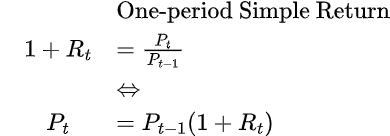

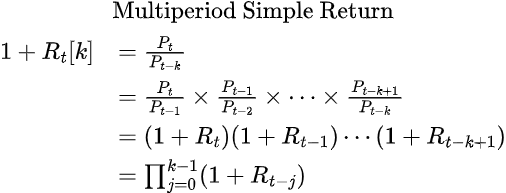

<b> 3. 연속복리 수익률(Continously Compounded Return) </b>
- 로그 수익률
- 퍼센트 수익률 r t = 100 * ln (P t / P t-1)

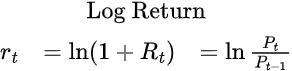

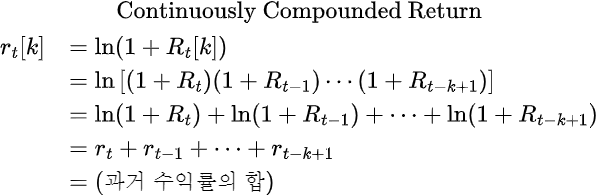

### 자본시장 시계열(수익률 분포)의 주요 통계적 속성

<b> 1. 일별 수익률 분포의 통계적 특성</b>
- (참고) 선행개념: 확률밀도함수(Probability Density Function, pdf)
- 왜도(skewness)가 높다 
  - 비대칭성
  - 정의: (확률밀도함수의 3rd central moment)
- 첨도(kurtosis)가 높다 
  - 두꺼운 꼬리분포(fat-tail)
  - 정의: (확률밀도함수의 4th central moment)
  - 정규분포의 경우 K(x) = 3이며, K(x) - 3 > 0 인 경우 첨도가 높다고 본다
  - 실무적으로는 정규분포에 비하여 극단값(extreme value)를 가질 확률이 높다는 뜻(leptokurtic)
  - 반대로 K(x) - 3 < 0 인 경우는 short-tail로 볼 수 있으며 극단적인 경우 uniform distribution over a finite interval 이 됨 (platykurtic)
- (일별, 월별, 연별) 수익률의 시계열적 특징: 자기 상관성이 없다 
  - 금융시장이 그만큼 Random Walk 하게 움직인다는 뜻

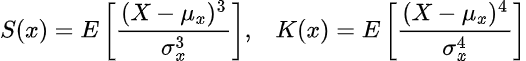

<b> 2. (c.f.) 자산 수익률을 측정하는 다른 방법</b> 
- APR (Annual Percentage Rate), CAGR (Compound Annual Growth Rate)

### 자본시장 시계열 데이터의 EDA (pandas 라이브러리로 시계열 다루기)

In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
import os
import warnings        
warnings.filterwarnings("ignore") 
%matplotlib inline

In [2]:
filename = 'https://github.com/mchoimis/tsdl/raw/main/market/tr_eod_data_rounded.csv'
data = pd.read_csv(filename,  index_col=0, parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [3]:
data.head()  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1096.35,NaN,NaN
2010-01-04,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-05,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-06,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
2010-01-07,30.08,30.45,20.60,130.00,177.67,114.19,1141.69,19.06,1.43,1131.90,49.10,110.82


In [4]:
data.tail()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2018-06-25,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.17,1265.00,22.01,119.89
2018-06-26,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26
2018-06-27,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.16,1251.62,21.81,118.58
2018-06-28,185.50,98.63,49.25,1701.45,223.42,270.89,2716.31,16.85,1.16,1247.88,21.93,118.22
2018-06-29,185.11,98.61,49.71,1699.80,220.57,271.28,2718.37,16.09,1.17,1252.25,22.31,118.65


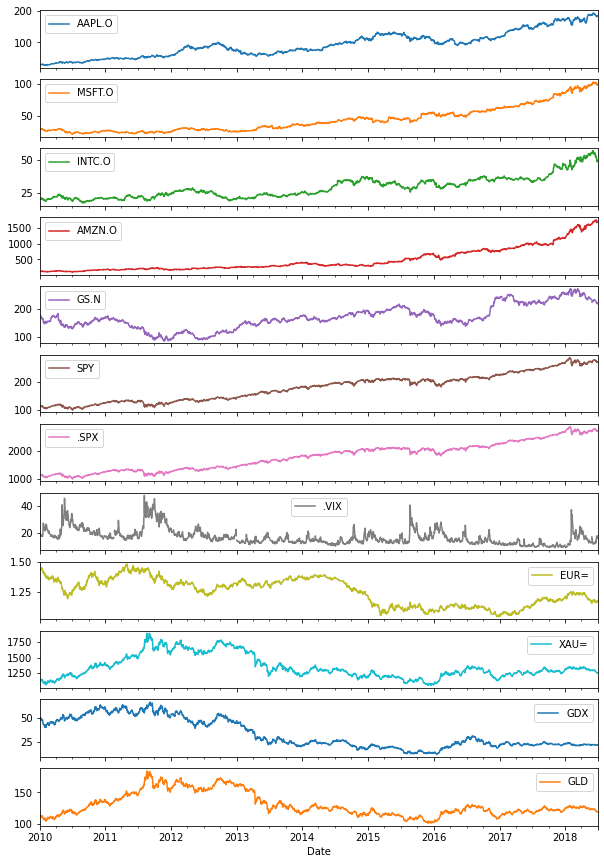

In [5]:
data.plot(figsize=(10, 15), subplots=True);

In [6]:
instruments = ['Apple Stock', 'Microsoft Stock',
               'Intel Stock', 'Amazon Stock', 'Goldman Sachs Stock',
               'SPDR S&P 500 ETF Trust', 'S&P 500 Index',
               'VIX Volatility Index', 'EUR/USD Exchange Rate',
               'Gold Price', 'VanEck Vectors Gold Miners ETF',
               'SPDR Gold Trust']

In [7]:
for ric, name in zip(data.columns, instruments):
    print('{:8s} | {}'.format(ric, name))

AAPL.O   | Apple Stock
MSFT.O   | Microsoft Stock
INTC.O   | Intel Stock
AMZN.O   | Amazon Stock
GS.N     | Goldman Sachs Stock
SPY      | SPDR S&P 500 ETF Trust
.SPX     | S&P 500 Index
.VIX     | VIX Volatility Index
EUR=     | EUR/USD Exchange Rate
XAU=     | Gold Price
GDX      | VanEck Vectors Gold Miners ETF
GLD      | SPDR Gold Trust


In [8]:
# Summary Stats
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [9]:
data.describe().round(2)  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
count,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2216.00,2211.00,2138.00,2138.00
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1349.01,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.75,15.17,18.78
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
25%,60.30,28.57,22.51,213.60,146.61,133.99,1338.57,13.07,1.13,1221.53,22.14,117.40
50%,90.56,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.61,25.62,124.00
75%,117.24,54.37,34.71,698.85,192.13,210.99,2108.94,19.07,1.35,1428.24,48.34,139.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1898.99,66.63,184.59


In [10]:
data.mean()

AAPL.O      93.456076
MSFT.O      44.561155
INTC.O      29.364210
AMZN.O     480.461258
GS.N       170.216221
SPY        180.323045
.SPX      1802.713106
.VIX        17.027133
EUR=         1.248696
XAU=      1349.014129
GDX         33.566515
GLD        130.086595
dtype: float64

In [11]:
data.aggregate([min,  
                np.mean,  
                np.std,  
                np.median,  
                max]  
).round(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1349.01,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.75,15.17,18.78
median,90.56,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.61,25.62,124.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1898.99,66.63,184.59


In [12]:
## Changes over time

data.diff().head()  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,23.65,NaN,NaN
2010-01-05,0.06,0.01,-0.01,0.79,3.06,0.30,3.53,-0.69,0.00,-1.35,0.46,-0.10
2010-01-06,-0.49,-0.19,-0.07,-2.44,-1.88,0.08,0.62,-0.19,0.00,19.85,1.17,1.81
2010-01-07,-0.06,-0.32,-0.20,-2.25,3.41,0.48,4.55,-0.10,-0.01,-6.60,-0.24,-0.69


In [13]:
data.diff().mean()  

AAPL.O    0.064745
MSFT.O    0.031252
INTC.O    0.013552
AMZN.O    0.706608
GS.N      0.028224
SPY       0.072101
.SPX      0.732659
.VIX     -0.019583
EUR=     -0.000117
XAU=      0.041887
GDX      -0.015070
GLD      -0.003455
dtype: float64

In [14]:
data.pct_change().round(3).head()  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007,0.022,NaN,NaN
2010-01-05,0.002,0.000,-0.000,0.006,0.018,0.003,0.003,-0.034,0.000,-0.001,0.010,-0.001
2010-01-06,-0.016,-0.006,-0.003,-0.018,-0.011,0.001,0.001,-0.010,0.000,0.018,0.024,0.016
2010-01-07,-0.002,-0.010,-0.010,-0.017,0.020,0.004,0.004,-0.005,-0.007,-0.006,-0.005,-0.006


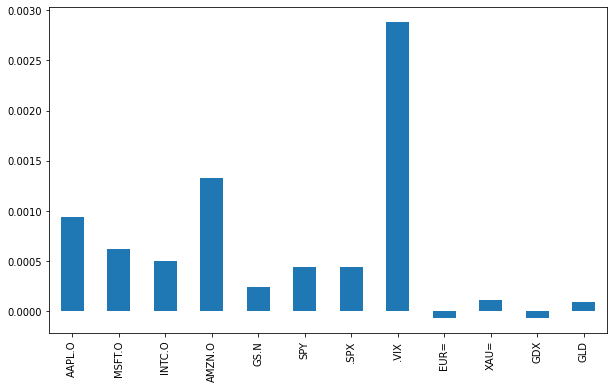

In [15]:
data.pct_change().mean().plot(kind='bar', figsize=(10, 6))

## <b> Ch 3. 금융시계열 이용하여 시장 예측하기 </b>

### 시계열을 금융분석에 응용하기

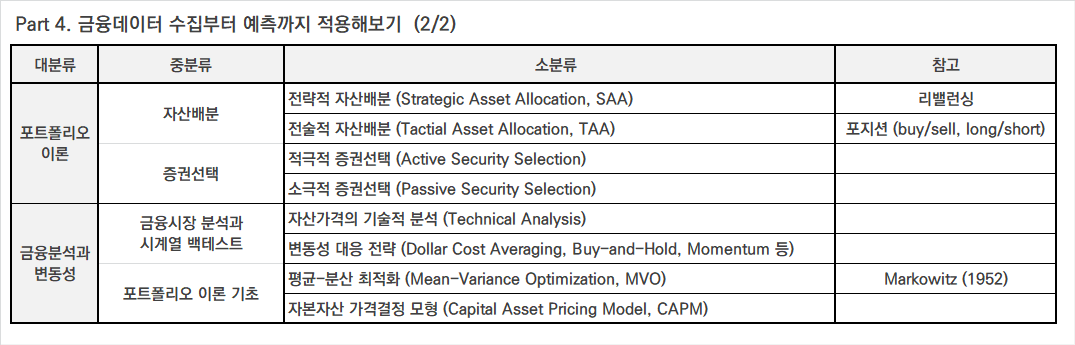

### 포트폴리오 최적화

In [16]:
# 로그 수익률 시계열 만들기

In [17]:
filename = 'https://github.com/mchoimis/tsdl/raw/main/market/tr_eod_data_rounded.csv'
data = pd.read_csv(filename,  index_col=0, parse_dates=True)

In [18]:
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1096.35,NaN,NaN
2010-01-04,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-05,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-06,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
2010-01-07,30.08,30.45,20.60,130.00,177.67,114.19,1141.69,19.06,1.43,1131.90,49.10,110.82
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.17,1265.00,22.01,119.89
2018-06-26,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26
2018-06-27,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.16,1251.62,21.81,118.58


In [19]:
data.shift(1)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1096.35,NaN,NaN
2010-01-05,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-06,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-07,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,184.92,100.41,52.50,1715.67,226.02,274.74,2754.88,13.77,1.17,1268.49,22.18,120.34
2018-06-26,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.17,1265.00,22.01,119.89
2018-06-27,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26


In [20]:
data.shift(periods=-1)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-04,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-05,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
2010-01-06,30.08,30.45,20.60,130.00,177.67,114.19,1141.69,19.06,1.43,1131.90,49.10,110.82
2010-01-07,30.28,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.44,1136.10,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26
2018-06-26,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.16,1251.62,21.81,118.58
2018-06-27,185.50,98.63,49.25,1701.45,223.42,270.89,2716.31,16.85,1.16,1247.88,21.93,118.22


In [21]:
rets = np.log(data / data.shift(1)) # 수익률 시계열 가장 간단하게 만드는 방법

In [22]:
symbols = ['AAPL', 'MSFT', 'INTC', 'AMZN', 'GS', 'SPY', 'SPX', 'VIX', 'EUR', 'XAU', 'GDX', 'GLD']
data_asset = data.copy()
data_asset.columns = symbols

In [23]:
rets_asset = np.log(data_asset / data_asset.shift(1)) # 자산이름 추가

In [24]:
rets_asset_summary = rets_asset[['AAPL', 'GS', 'SPY', 'VIX', 'GLD']] # 일부 종목 추출

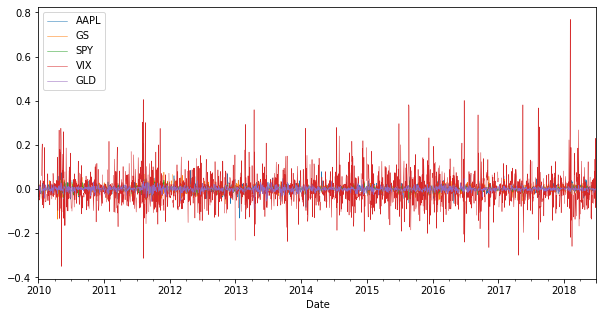

In [25]:
# Daily Return Visualized
rets_asset_summary .plot(figsize=(10, 5), lw=0.5)

In [26]:
# 일간 수익률을 연율화
rets.mean( )* 252

AAPL.O    0.181369
MSFT.O    0.124881
INTC.O    0.096782
AMZN.O    0.287548
GS.N      0.028561
SPY       0.097282
.SPX      0.098986
.VIX     -0.293504
EUR=     -0.022830
XAU=      0.009427
GDX      -0.104020
GLD      -0.003784
dtype: float64

In [27]:
ret = rets.dropna()

In [28]:
# 공분산 행렬
rets.cov() * 252

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
AAPL.O,0.064026,0.023646,0.023639,0.027066,0.023499,0.021151,0.021235,-0.144459,0.002032,0.001226,0.014513,0.001424
MSFT.O,0.023646,0.051201,0.030287,0.030386,0.026774,0.022389,0.022518,-0.149149,0.002453,-0.000382,0.010894,-0.000372
INTC.O,0.023639,0.030287,0.056405,0.025005,0.027758,0.022801,0.022903,-0.151103,0.003371,0.000144,0.012782,0.000170
AMZN.O,0.027066,0.030386,0.025005,0.095836,0.026640,0.024298,0.024449,-0.171029,0.003552,-0.001377,0.010232,-0.001364
GS.N,0.023499,0.026774,0.027758,0.026640,0.069593,0.028021,0.028125,-0.185918,0.004005,-0.002703,0.008299,-0.002603
SPY,0.021151,0.022389,0.022801,0.024298,0.028021,0.022050,0.022018,-0.146152,0.003563,0.000047,0.011889,0.000107
.SPX,0.021235,0.022518,0.022903,0.024449,0.028125,0.022018,0.022158,-0.147143,0.003596,0.000139,0.012039,0.000193
.VIX,-0.144459,-0.149149,-0.151103,-0.171029,-0.185918,-0.146152,-0.147143,1.502097,-0.018502,-0.000343,-0.077766,-0.000078
EUR=,0.002032,0.002453,0.003371,0.003552,0.004005,0.003563,0.003596,-0.018502,0.011256,0.004500,0.011675,0.004672
XAU=,0.001226,-0.000382,0.000144,-0.001377,-0.002703,0.000047,0.000139,-0.000343,0.004500,0.024912,0.044644,0.025450


In [29]:
# import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from scipy.optimize import minimize
# import matplotlib.pyplot as plt
# %matplotlib inline

In [30]:
# pdf 생성 위한 인수
r = 0.05
M = 2061
sigma = 0.2

In [31]:
log_return = np.array(ret['SPY'])
log_return

array([ 0.00264364,  0.00070379,  0.00421238, ..., -0.00831875,
        0.00570119,  0.00143866])

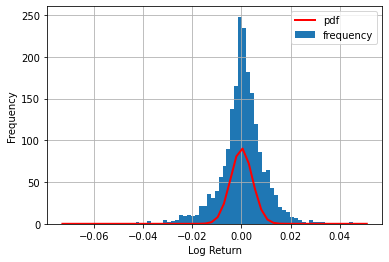

In [32]:
plt.hist(log_return.flatten(), bins=70, label='frequency')
plt.grid(True)
plt.xlabel('Log Return')
plt.ylabel('Frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=r/M, scale=sigma/np.sqrt(M)), 'r', lw=2, label='pdf')
plt.legend()

In [33]:
# SciPy에서 수익률 데이터의 통계량 구하기
# scs.describe(log_return)

In [34]:
def print_statistics(array):
  sta = scs.describe(array)
  print('Statistic (통계량) |', 'Value (값)')
  print('--------------------')
  print('size |', sta[0])
  print('min |', sta[1][0])
  print('max |', sta[1][1])
  print('mean |', sta[2])
  print('std |', np.sqrt(sta[3]))
  print('skew|', sta[4])
  print('kurtosis |', sta[5])

In [35]:
print_statistics(log_return)

Statistic (통계량) | Value (값)
--------------------
size | 2061
min | -0.06734057781115321
max | 0.045450496816366155
mean | 0.00038603872907587357
std | 0.009354127350938931
skew| -0.5386276197067666
kurtosis | 4.611347558478201


In [36]:
# print("Skewness: {:.7f}".format( scs.skew(log_return)) )
print("Skewness Test p-value: {:.7f}".format( scs.skewtest(log_return)[1]) ) # 샘플의 왜도가 정규분포와 일치하는지(0에 가까운 값을 가지는지 판단)
# print("Kurtosis: {:.7f}".format( scs.kurtosis(log_return)) )
print("Kurtosis Test p-value: {:.7f}".format( scs.kurtosistest(log_return)[1]) ) # 샘플의 첨도가 정규분포와 일치하는지(0에 가까운 값을 가지는지 판단)
print("Normality Test p-value: {:.7f}".format( scs.normaltest(log_return)[1]) ) # 영가설: 샘플의 분포가 정규분포이다. (유의확률이 클수록 정규분포 가설을 강하게 지지)

Skewness Test p-value: 0.0000000
Kurtosis Test p-value: 0.0000000
Normality Test p-value: 0.0000000


Text(0.5, 1.0, 'Log Return Series Q-Q Plot')

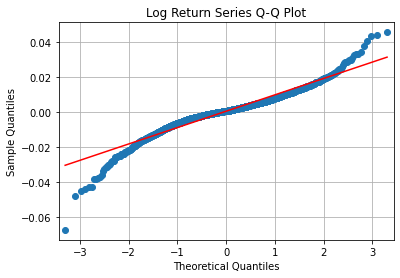

In [37]:
sm.qqplot(log_return.flatten(), line='s')
plt.grid(True)
plt.xlabel("Theoretical Quantiles") #  (정규분포 상의 이론적 분위수)
plt.ylabel("Sample Quantiles") # (샘플 분위수)
plt.title("Log Return Series Q-Q Plot") # 강한 fat-tail

In [38]:
rets.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f638e5875b0>,
      dtype=object)

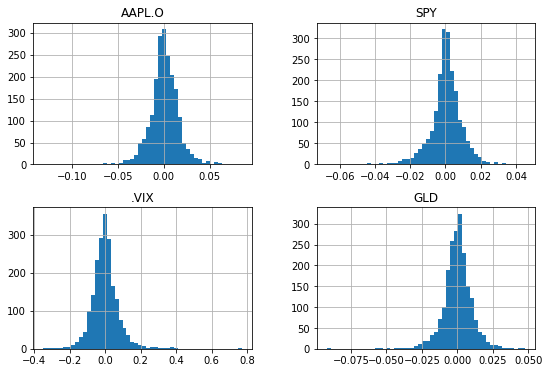

In [39]:
log_returns = rets[['AAPL.O','SPY','.VIX', 'GLD']]
log_returns.hist(bins=50, figsize=(9, 6))

In [40]:
# 포트폴리오 이론 기초

In [41]:
rets_asset_summary.columns

Index(['AAPL', 'GS', 'SPY', 'VIX', 'GLD'], dtype='object')

In [42]:
np.random.seed(813)
noa = len(rets_asset_summary.columns)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.36667945, 0.3232487 , 0.09668174, 0.00235596, 0.21103415])

In [43]:
np.sum(rets_asset_summary.mean()*weights) * 252

0.08365183918390344

In [44]:
prets = [] # portfolio return
pvols = [] # poortfolio volatility
for p in range(2500):
  weights = np.random.random(noa)
  weights /= np.sum(weights)
  prets.append(np.sum(rets_asset_summary.mean() * weights) * 252)
  pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets_asset_summary.cov() * 252, weights))))

prets = np.array(prets)
pvols = np.array(pvols)

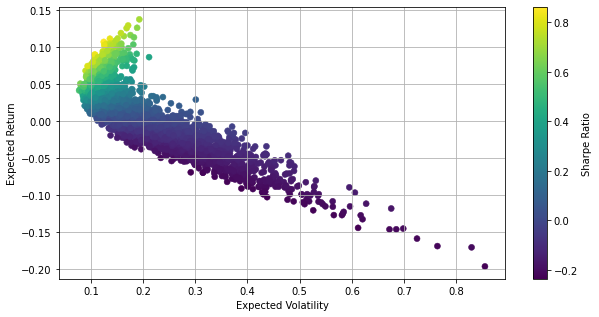

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', lw=0.5)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio') # objective

In [46]:
# Portfolio Optimization

In [47]:
def statistics(weights):
  weights = np.array(weights)
  pret = np.sum(rets_asset_summary.mean() * weights) * 252
  pvol = np.sqrt(np.dot(weights.T, np.dot(rets_asset_summary.cov() * 252, weights)))
  return np.array([pret, pvol, pret/pvol])

In [48]:
def min_sharpe(weights):
  return statistics(weights)[2]  * (-1)

In [49]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(noa))

In [50]:
optimize = minimize(min_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bounds, constraints=constraints)
optimize

     fun: -0.9216716127758776
     jac: array([ 1.29088759e-04,  9.20430951e-01,  2.07185745e-04, -2.51206756e-03,
        7.77706355e-02])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.15494808e-01, 5.56333813e-16, 7.14529361e-01, 6.99758311e-02,
       0.00000000e+00])

In [51]:
optimize.x.round(3)

array([0.215, 0.   , 0.715, 0.07 , 0.   ])

In [52]:
statistics(optimize.x.round(3)) # [pret, pvol, pret/pvol]

array([0.0880055, 0.0954847, 0.9216712])

### 자산가격 시계열의 기술적 분석과 매매전략

In [53]:
# 기술적 분석

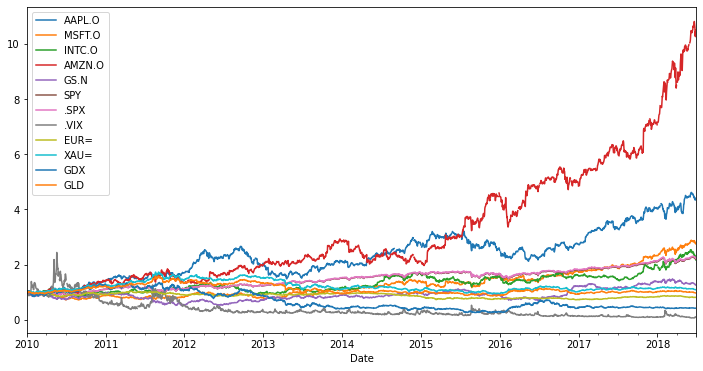

In [54]:
rets.cumsum().apply(np.exp).plot(figsize=(12, 6))
plt.show()

In [55]:
# 시계열의 Sampling
data.resample('1w', label='right').last().head()  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1096.35,NaN,NaN
2010-01-10,30.28,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.44,1136.10,49.84,111.37
2010-01-17,29.42,30.86,20.80,127.14,165.21,113.64,1136.03,17.91,1.44,1129.90,47.42,110.86
2010-01-24,28.25,28.96,19.91,121.43,154.12,109.21,1091.76,27.31,1.41,1092.60,43.79,107.17
2010-01-31,27.44,28.18,19.40,125.41,148.72,107.39,1073.87,24.62,1.39,1081.05,40.72,105.96


In [56]:
data.resample('1m', label='right').last().head()  

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-31,27.44,28.18,19.40,125.41,148.72,107.39,1073.87,24.62,1.39,1081.05,40.72,105.96
2010-02-28,29.23,28.67,20.53,118.40,156.35,110.74,1104.49,19.50,1.36,1116.10,43.89,109.43
2010-03-31,33.57,29.29,22.29,135.77,170.63,117.00,1169.43,17.59,1.35,1112.80,44.41,108.95
2010-04-30,37.30,30.54,22.84,137.10,145.20,118.81,1186.69,22.05,1.33,1178.25,50.51,115.36
2010-05-31,36.70,25.80,21.42,125.46,144.26,109.37,1089.41,32.07,1.23,1215.71,49.86,118.88


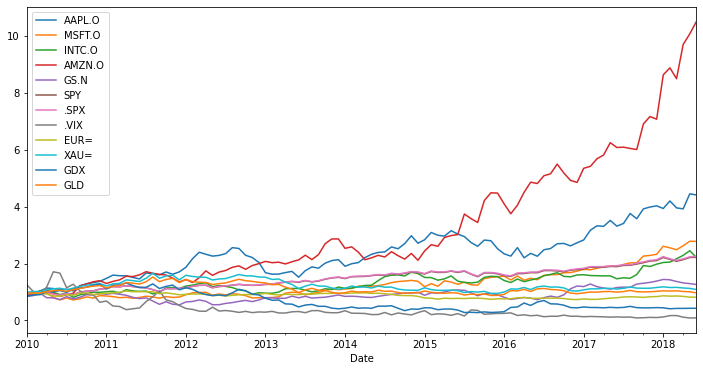

In [57]:
rets.cumsum().apply(np.exp).resample('1m', label='right').last().plot(figsize=(12, 6)) # 월간 수익률

In [58]:
## 시계열의 Rolling Statistics 구하기

sym = 'AAPL.O'
data = pd.DataFrame(data[sym]).dropna()
data.tail()

,AAPL.O
Date,
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16
2018-06-28,185.50
2018-06-29,185.11


In [59]:
import math
window = 20
data[sym].rolling(window=window).std() * math.sqrt(window)

Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08          NaN
                ...    
2018-06-25    14.590562
2018-06-26    15.312285
2018-06-27    16.012419
2018-06-28    16.248997
2018-06-29    16.575959
Name: AAPL.O, Length: 2138, dtype: float64

In [60]:
## 특정 기간 동안의 Rolling 지표 구하기 
window = 20  

data['min'] = data[sym].rolling(window=window).min()  
data['mean'] = data[sym].rolling(window=window).mean()  
data['std'] = data[sym].rolling(window=window).std()  
data['median'] = data[sym].rolling(window=window).median()  
data['max'] = data[sym].rolling(window=window).max()  
data['ewma'] = data[sym].ewm(halflife=0.5, min_periods=window).mean() # Exponentially Weighted Moving Average

data.dropna().head()

,AAPL.O,min,mean,std,median,max,ewma
Date,,,,,,,
2010-02-01,27.82,27.44,29.5810,0.933313,29.820,30.72,27.807013
2010-02-02,27.98,27.44,29.4515,0.967908,29.710,30.72,27.936753
2010-02-03,28.46,27.44,29.3430,0.950314,29.685,30.72,28.329188
2010-02-04,27.44,27.44,29.2080,1.020333,29.545,30.72,27.662297
2010-02-05,27.92,27.44,29.1000,1.037350,29.420,30.72,27.855574


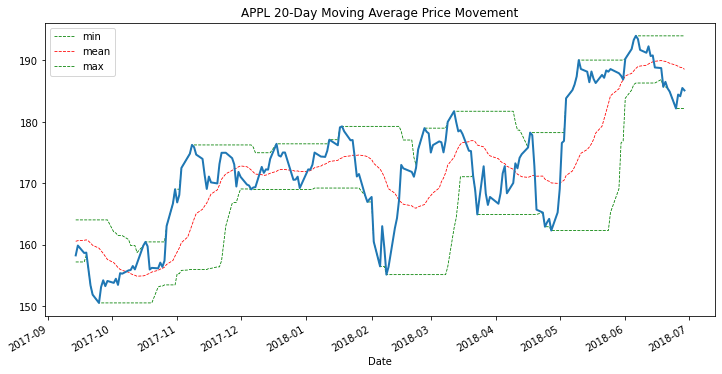

In [61]:
# Price Movement의 시각화
ax = data[['min', 'mean', 'max']].iloc[-200:].plot(figsize=(12, 6), style=['g--', 'r--', 'g--'], lw=0.8)  
data[sym].iloc[-200:].plot(ax=ax, lw=2.0)
plt.title("APPL 20-Day Moving Average Price Movement") # 구간화
plt.show()

In [62]:
###  자본시장 시계열의 기술적 분석
data['SMA1'] = data[sym].rolling(window=42).mean()  # short-term
data['SMA2'] = data[sym].rolling(window=252).mean()  # long-term
data[[sym, 'SMA1', 'SMA2']].tail()

,AAPL.O,SMA1,SMA2
Date,,,
2018-06-25,182.17,185.606190,168.265556
2018-06-26,184.43,186.087381,168.418770
2018-06-27,184.16,186.607381,168.579206
2018-06-28,185.50,187.089286,168.736627
2018-06-29,185.11,187.470476,168.901032


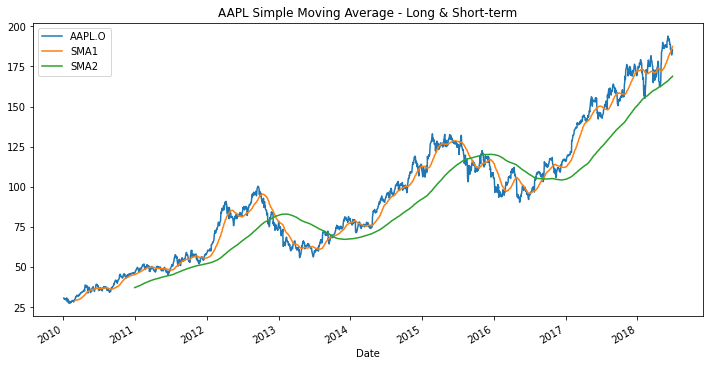

In [63]:
data[[sym, 'SMA1', 'SMA2']].plot(figsize=(12, 6))
plt.title("AAPL Simple Moving Average - Long & Short-term")
plt.show()

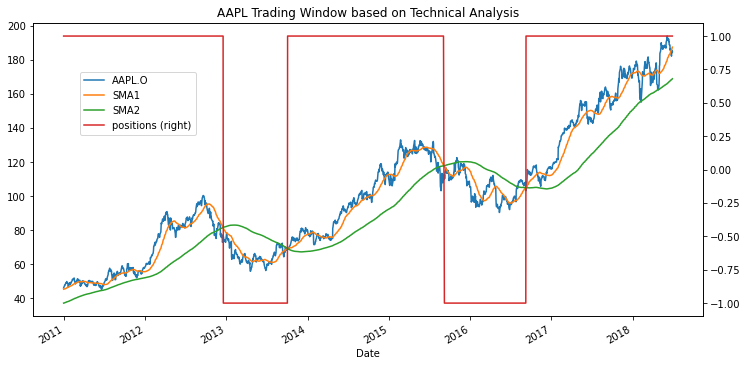

In [64]:
### 가격 추이에 따른 포지션(Trading Strategy)
# 예시: 골든 크로스(Golden Cross), 데드 크로스(Dead Cross)

data.dropna(inplace=True)  

data['positions'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  # 1: buy , -1: sell /

ax = data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(12, 6), secondary_y='positions') 
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

plt.title("AAPL Trading Window based on Technical Analysis")
plt.show()

### Auto ARIMA로 자산가격 예측하기

In [65]:
## Auto Arima(p, d, q) 실습

In [66]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
import os
import warnings        
warnings.filterwarnings("ignore") 
%matplotlib inline

In [68]:
import pmdarima as pm
from pmdarima.arima import ndiffs

In [69]:
filename = 'https://github.com/mchoimis/tsdl/raw/main/market/tr_eod_data_rounded.csv'
data = pd.read_csv(filename, index_col=0, parse_dates=True)

In [70]:
# 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악

In [71]:
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1096.35,NaN,NaN
2010-01-04,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-05,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-06,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
2010-01-07,30.08,30.45,20.60,130.00,177.67,114.19,1141.69,19.06,1.43,1131.90,49.10,110.82
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.17,1265.00,22.01,119.89
2018-06-26,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26
2018-06-27,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.16,1251.62,21.81,118.58


In [72]:
data_y = data.dropna()

In [73]:
data_y

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.57,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.44,1120.00,47.71,109.80
2010-01-05,30.63,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.44,1118.65,48.17,109.70
2010-01-06,30.14,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.44,1138.50,49.34,111.51
2010-01-07,30.08,30.45,20.60,130.00,177.67,114.19,1141.69,19.06,1.43,1131.90,49.10,110.82
2010-01-08,30.28,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.44,1136.10,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.17,1265.00,22.01,119.89
2018-06-26,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.16,1258.64,21.95,119.26
2018-06-27,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.16,1251.62,21.81,118.58


In [74]:
y = data_y[['AAPL.O']].iloc[-200:]
y

,AAPL.O
Date,
2017-09-14,158.28
2017-09-15,159.88
2017-09-18,158.67
2017-09-19,158.73
2017-09-20,156.07
...,...
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16


In [75]:
ndiffs(y) # 차수

1

In [76]:
y_train = y['AAPL.O'][:int(0.7*len(y))]
y_test = y['AAPL.O'][int(0.7*len(y)):] 

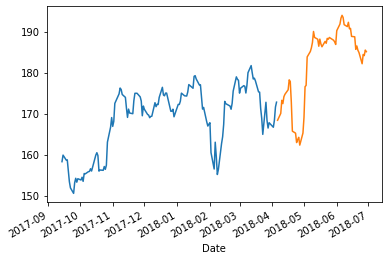

In [77]:
y_train.plot()
y_test.plot()

In [78]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"d = {n_diffs}")

d = 1


In [79]:
model = pm.auto_arima(y = y_train       # 데이터
                      , d = 1           # (d)차분 차수 (기본값 = none), 지정하지 않으면 실행 기간이 매우 길어질 수 있음
                      , start_p = 0     # (p)탐색 시초값 (기본값 = 2)
                      , max_p = 3       # (기본값 = 5)
                      , start_q = 0     # (q)탐색 시초값 (기본값 = 2)
                      , max_q = 3       # (기본값 = 5)
                      , m = 1           # (기본값 = 1)
                      , seasonal = False # 기본값 = True, 계절변동 ARIMA(SARIMA)에 해당시 True로 수정
                      , stepwise = True  
                      , trace=True      # stepwise로 모델을 적합할 때마다 결과를 프린트
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=632.062, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=633.161, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=632.943, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.345, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=633.865, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.449 seconds


In [80]:
model = pm.auto_arima (y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=632.062, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=633.161, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=632.943, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.345, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=633.865, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.244 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [81]:
# 잔차 검정
# 잔차가 백색잡음 과정인지 (=정상성을 만족하는지), 정규성 및 등분산성을 만족하는지 파악합

# 1. summary 결과에서 Ljung-Box (Q) / Heteroskedasticity (H) / Jarque-Bera (JB) 검정 만족 여부를 파악
# 2. plot_diagnostics 잔차 그래프로 정상성과 정규성을 만족하는지 파악

In [82]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  140
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -314.172
Date:                Sat, 17 Dec 2022   AIC                            630.345
Time:                        11:49:09   BIC                            633.279
Sample:                             0   HQIC                           631.537
                                - 140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.3795      0.509     10.576      0.000       4.383       6.376
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                 9.58
Prob(Q):                              0.34   Pr

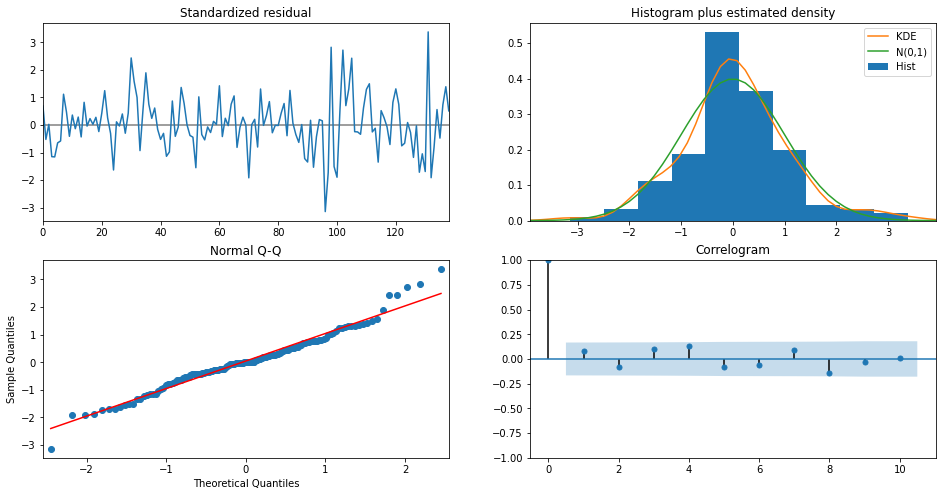

In [83]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [84]:
# 모형 예측

In [85]:
y_train.head(5)

Date
2017-09-14    158.28
2017-09-15    159.88
2017-09-18    158.67
2017-09-19    158.73
2017-09-20    156.07
Name: AAPL.O, dtype: float64

In [86]:
y_test

Date
2018-04-06    168.38
2018-04-09    170.05
2018-04-10    173.25
2018-04-11    172.44
2018-04-12    174.14
2018-04-13    174.73
2018-04-16    175.82
2018-04-17    178.24
2018-04-18    177.84
2018-04-19    172.80
2018-04-20    165.72
2018-04-23    165.24
2018-04-24    162.94
2018-04-25    163.65
2018-04-26    164.22
2018-04-27    162.32
2018-04-30    165.26
2018-05-01    169.10
2018-05-02    176.57
2018-05-03    176.89
2018-05-04    183.83
2018-05-07    185.16
2018-05-08    186.05
2018-05-09    187.36
2018-05-10    190.04
2018-05-11    188.59
2018-05-14    188.15
2018-05-15    186.44
2018-05-16    188.18
2018-05-17    186.99
2018-05-18    186.31
2018-05-21    187.63
2018-05-22    187.16
2018-05-23    188.36
2018-05-24    188.15
2018-05-25    188.58
2018-05-29    187.90
2018-05-30    187.50
2018-05-31    186.87
2018-06-01    190.24
2018-06-04    191.83
2018-06-05    193.31
2018-06-06    193.98
2018-06-07    193.46
2018-06-08    191.70
2018-06-11    191.23
2018-06-12    192.28
2018-06-

In [87]:
y_pred = model.predict(n_periods=len(y_test)) # Test 기간 = 60일 

In [88]:
y_pred

140    172.8
141    172.8
142    172.8
143    172.8
144    172.8
145    172.8
146    172.8
147    172.8
148    172.8
149    172.8
150    172.8
151    172.8
152    172.8
153    172.8
154    172.8
155    172.8
156    172.8
157    172.8
158    172.8
159    172.8
160    172.8
161    172.8
162    172.8
163    172.8
164    172.8
165    172.8
166    172.8
167    172.8
168    172.8
169    172.8
170    172.8
171    172.8
172    172.8
173    172.8
174    172.8
175    172.8
176    172.8
177    172.8
178    172.8
179    172.8
180    172.8
181    172.8
182    172.8
183    172.8
184    172.8
185    172.8
186    172.8
187    172.8
188    172.8
189    172.8
190    172.8
191    172.8
192    172.8
193    172.8
194    172.8
195    172.8
196    172.8
197    172.8
198    172.8
199    172.8
dtype: float64

In [89]:
y_test_predict_df = pd.DataFrame({"test": y_test, "pred": y_pred})
y_predict_df = y_test_predict_df['pred']
y_predict_df

1970-01-01 00:00:00.000000140   NaN
1970-01-01 00:00:00.000000141   NaN
1970-01-01 00:00:00.000000142   NaN
1970-01-01 00:00:00.000000143   NaN
1970-01-01 00:00:00.000000144   NaN
                                 ..
2018-06-25 00:00:00.000000000   NaN
2018-06-26 00:00:00.000000000   NaN
2018-06-27 00:00:00.000000000   NaN
2018-06-28 00:00:00.000000000   NaN
2018-06-29 00:00:00.000000000   NaN
Name: pred, Length: 120, dtype: float64

In [90]:
# 모델 업데이트 설정

In [91]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)               
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [92]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트
    model.update(new_ob)

In [93]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2018-04-06,168.38,172.80
2018-04-09,170.05,168.38
2018-04-10,173.25,170.05
2018-04-11,172.44,173.25
2018-04-12,174.14,172.44
2018-04-13,174.73,174.14
2018-04-16,175.82,174.73
2018-04-17,178.24,175.82
2018-04-18,177.84,178.24


In [94]:
# 결과의 해석

In [95]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -451.049
Date:                Sat, 17 Dec 2022   AIC                            904.098
Time:                        11:49:11   BIC                            907.391
Sample:                             0   HQIC                           905.431
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.4481      0.410     13.288      0.000       4.645       6.252
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):                20.51
Prob(Q):                              0.08   Pr

In [96]:
y_test_predict_df = pd.DataFrame({"test": y_test, "pred": y_pred})
y_predict_df = y_test_predict_df['pred']
y_predict_df

Date
2018-04-06    172.80
2018-04-09    168.38
2018-04-10    170.05
2018-04-11    173.25
2018-04-12    172.44
2018-04-13    174.14
2018-04-16    174.73
2018-04-17    175.82
2018-04-18    178.24
2018-04-19    177.84
2018-04-20    172.80
2018-04-23    165.72
2018-04-24    165.24
2018-04-25    162.94
2018-04-26    163.65
2018-04-27    164.22
2018-04-30    162.32
2018-05-01    165.26
2018-05-02    169.10
2018-05-03    176.57
2018-05-04    176.89
2018-05-07    183.83
2018-05-08    185.16
2018-05-09    186.05
2018-05-10    187.36
2018-05-11    190.04
2018-05-14    188.59
2018-05-15    188.15
2018-05-16    186.44
2018-05-17    188.18
2018-05-18    186.99
2018-05-21    186.31
2018-05-22    187.63
2018-05-23    187.16
2018-05-24    188.36
2018-05-25    188.15
2018-05-29    188.58
2018-05-30    187.90
2018-05-31    187.50
2018-06-01    186.87
2018-06-04    190.24
2018-06-05    191.83
2018-06-06    193.31
2018-06-07    193.98
2018-06-08    193.46
2018-06-11    191.70
2018-06-12    191.23
2018-06-

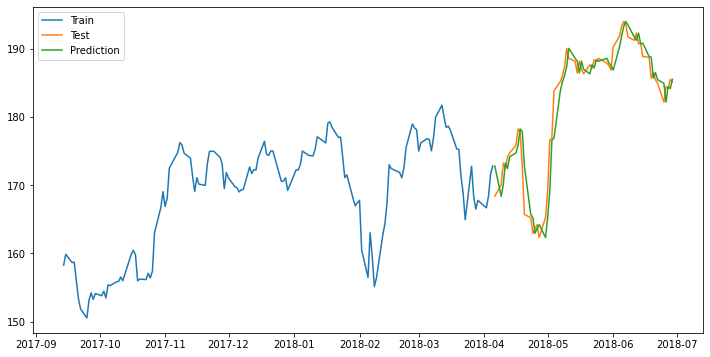

In [97]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
plt.plot(y_train, label='Train')        
plt.plot(y_test, label='Test')          
plt.plot(y_predict_df, label='Prediction')   
plt.legend()
plt.show()

In [98]:
# 시계열 모형의 평가 (mean absolute percentage error)

In [99]:
def MAPE(y_test, y_pred): 
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE (%): {MAPE(y_test, y_pred):.3f}")

MAPE (%): 0.949


## <b> Ch 4. 금융시계열과 추가 변수를 이용한 시장 예측해 보기 </b>

### 변동성의 개념과 모형의 필요성
- 금융시계열에서 수익률의 분산을 보는 이유
  - t시점의 수익률 = 100 * ln(xt / xt-1)
- 시간가변하는 변동성을 모형화하는 경우, 분산이 시점 t에 의존하므로, t-1기까지의 정보를 이용하여 변동성을 측정하는 조건부 분산이 예측오차를 줄일 수 있다는 장점을 가진다
- 지금까지 다룬 시계열 분석은 **다른 변수** 또는 **해당 변수 자체의 과거값**의 변화에 대응하는 종속변수의 평균적인 변화 분석에 초점을 둠
  - 따라서 회귀모형 또는 시계열 모형에 포함되는 오차항에 대한 정보는 추정값에 대한 통계적 추론을 위하여 보조적 역할이었음
- 금융시장의 변동성은 시간에 따라 변화하는 것이 일반적 
  - 변동성이 커진다는 것은 일반적으로 자산시장으로 유입되는 정보의 양이 많아짐을 뜻함
  - 예) FOMC 금리 발표, 신흥국 환 위기, 유럽발 재정위기, 산유국 감산 소식 등
- 금융시장에서 변동성에 대한 관심이 증가함에 따라 금융시계열의 **분산**(variance) 및 **공분산**(covariance) 등에 대한 추정과 예측이 필요

- 변동성
  - 변동성은 자산 수익의 표준편차 혹은 분산으로 측정됨
- 대부분의 금융시계열은 변동성의 군집현상(volatility clustering)이 나타남
  - <b>오차항의 분산이 일정하다</b>는 OLS 회귀모형의 기본 가정을 <b>위배</b>
  - 기준금리를 비롯한 각종 경제지표의 발표, 금융위기, 재정 위기와 같은 외부 충격(shock)에 영향을 받는다는 의미
  - 이러한 충격이 일정기간 동안 영향을 미치게 되므로 시계열상 <b>이분산성</b>이 발생
- 조건부 분산
  - x 의 값을 알고 있을 때 이에 대한 조건부확률분포 p(y|x)의 분산
  - 예측문제의 관점으로 보면 조건부분산은 예측의 불확실성를 뜻함
- 조건부 이분산성 (Conditional Heteoskedasticity)
  - 오차항의 분산과 독립변수가 일정한 관계를 가질 수 있다 

### 변동성 모형: ARCH, GARCH 

<b>ARCH</b> (AutoRegressive Conditional Heteroskedasticity)
- ARCH 는 Engle(1982)에 의해 제시되었으며, 오차항의 분산의 현재값이 이전의 오차항의 제곱값들에 의존할 것이라는 접근에서 출발
- "바로 직전의 오차항의 제곱값에 의존": &sigma;t^2 = &alpha;0 + &alpha;1 * 
&varepsilon;t-1 ^2
- 전체 모형은 조건부 평균과 분산에 대해 두 개의 구별되는 모형을 포함함

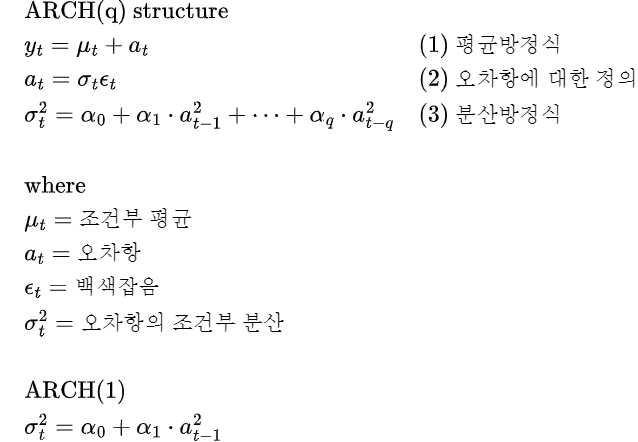

- ARCH 모형의 문제점
  - 양(+)의 shock과 음(-)의 shock을 동일하게 다루고 있음(과거 shock의 제곱값) 
  - : 실제로는 방향에 따라 비대칭적인 영향력을 보일 때가 많다 
  - ARCH 의 차수를 어떻게 결정해야 하는가?
  - : 실제로 필요한 q 값이 상당히 클 수가 있음
  - 조건부 분산이 양(+)이 되기 위한 충분조건은 파라미터가 모두 비음성(non-negative)이어야 함
  - : 추정해야하는 모수가 많아지는 경우 이러한 제약이 충족되지 않을 수 있음

<b>GARCH</b> (Generalized AutoRegressive Conditional Heteroskedasticity)
- ARCH 모형과 달리, GARCH 모형은 변동성의 시계열 의존성, 즉 자기상관을 표현하는 데 있어서 모수의 수를 줄일 수 있다는 장점
- GARCH 모형은 조건부분산이 직전의 오차항의 제곱값과 함께 자체 시차값(lagged values)에 의존하도록 함
- GARCH (1,1)
  - (1) Yt = &gamma;0 + &gamma;1* X1t + ... +  &gamma;k*Xkt + &varepsilon;t
  - (2) &sigma;t^2 = &omega; + &alpha;0 + &alpha;1 * 
&varepsilon;t-1 ^2 + ... + &alpha;q * &varepsilon;t-q ^2 
  - 조건부 평균에 대한 식 (1) 은 외생 변수 및 오차항의 함수로 표현됨

- GARCH(1, 1) = ARCH(∞) 모형이므로 추정해야 하는 모수의 수를 줄일 수 있다는 장점

### 벡터자기회귀(Vector AutoRegressive Model, VAR)

- 실증분석에서는 2개 이상의 시계열을 동시에 모형화하는 것이 유리
- 자산시장를 비롯한 거시경제 시계열은 서로 독립적으로 움직이는 것이 아니라 일정한 상관관계를 보이는 편
- 벡터자기회귀(VAR)은 k개의 AR식을 벡터로 쌓은 것과 같다 
- 다만 단일 시계열 AR과 다른 점은 설명변수로 자기 자신의 lag뿐 아니라 다른 변수들의 lag도 포함한다는 점

In [100]:
# Python `statsmodels` Datasets Package
# # https://www.statsmodels.org/0.6.1/datasets/index.html
# US Marcroecnomic Data
# # https://www.statsmodels.org/0.6.1/datasets/generated/macrodata.html

In [101]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [102]:
# Load data
mdata = sm.datasets.macrodata.load_pandas().data
mdata

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [103]:
df = mdata.copy()

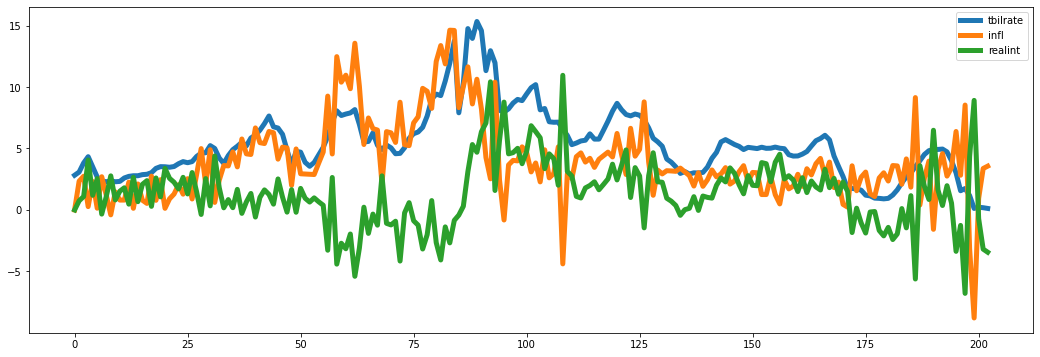

In [104]:
mdata[['tbilrate', 'infl',	'realint']].plot(figsize=(18, 6), linewidth=5)

In [105]:
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]

In [106]:
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

In [107]:
mdata = mdata[['realgdp','realcons','realinv']] # select 3 series
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

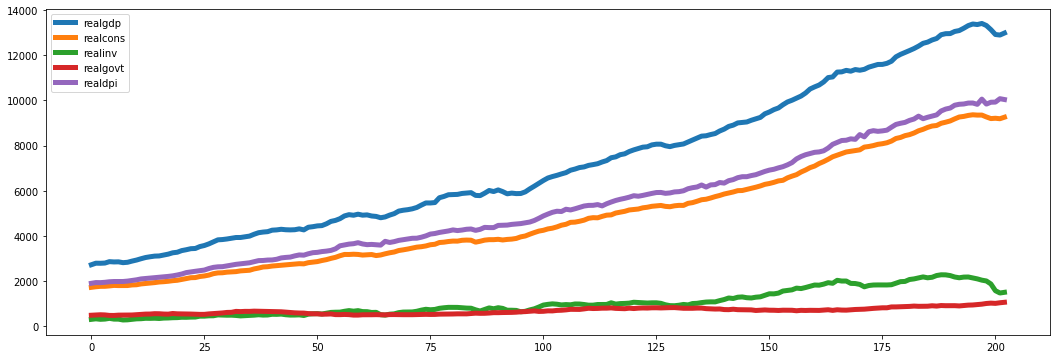

In [108]:
import matplotlib.pyplot as plt
df[['realgdp',	'realcons',	'realinv',	'realgovt',	'realdpi']].plot(figsize=(18, 6), linewidth=5)

In [109]:
# EDA

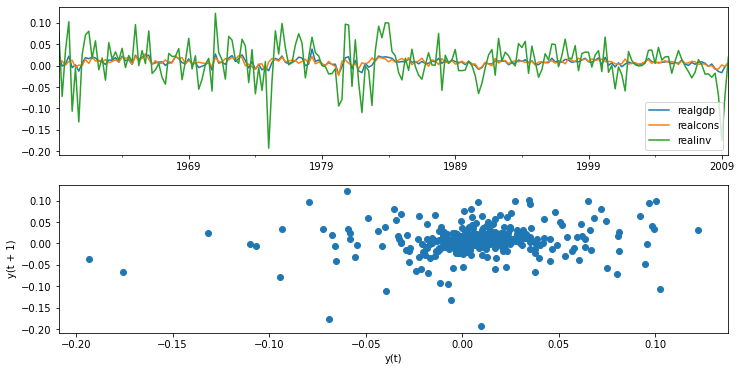

In [110]:
# Visualize serial correlations 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
data.plot(ax=ax1) # series plot
pd.plotting.lag_plot(data) # lag plot # Random series does not exhibit a structure in the lag plot.
plt.show() 

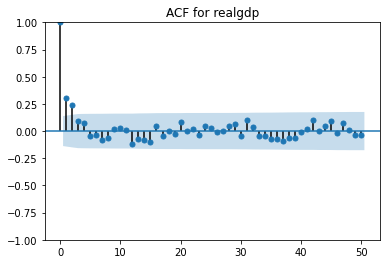

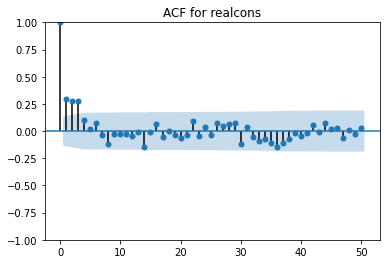

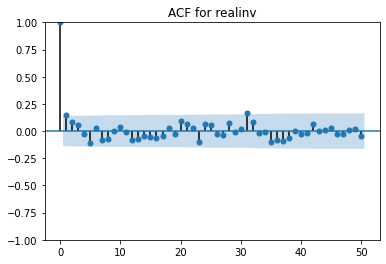

In [111]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
for i in data:
  plot_acf(data[i], lags=50)
  plt.title('ACF for %s' % i)
  plt.show()

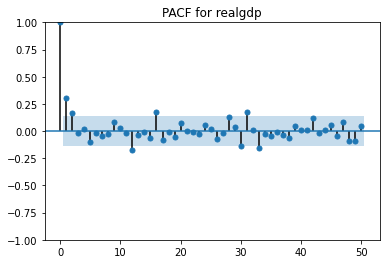

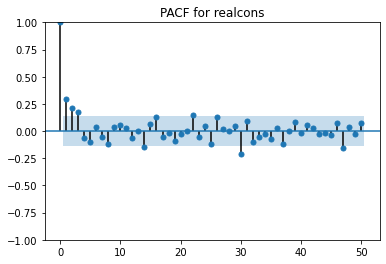

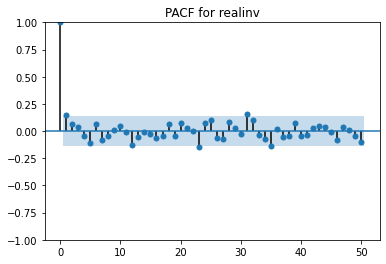

In [112]:
from statsmodels.graphics.tsaplots import plot_pacf
for i in data:
  plot_pacf(data[i], lags=50)
  plt.title('PACF for %s' % i)
  plt.show()

In [113]:
# Stationarity Check
# (H0): non-stationary
# (H1): stationary

from statsmodels.tsa.stattools import adfuller
def adf(time_series):
  result = adfuller(time_series.values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

for i in data:
  print('--Test statistic for %s' % i)
  adf(data[i])

--Test statistic for realgdp
ADF Statistic: -6.972871
p-value: 0.000000
--Test statistic for realcons
ADF Statistic: -4.991971
p-value: 0.000023
--Test statistic for realinv
ADF Statistic: -12.218963
p-value: 0.000000


In [114]:
obs = 5
X_train, X_test = data[0:-obs], data[-obs:]

print(X_train.shape)
print(X_test.shape)

(197, 3)
(5, 3)


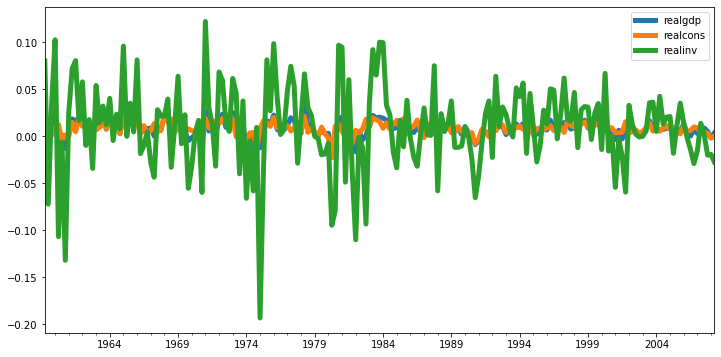

In [115]:
X_train.plot(figsize=(12, 6), linewidth=5)
plt.show()

In [116]:
model_var = VAR(endog=X_train)
res = model_var.select_order(6)
res.summary()

,AIC,BIC,FPE,HQIC
0,-27.82,-27.77,8.281e-13,-27.80
1,-28.10*,-27.89*,6.277e-13*,-28.01*
2,-28.07,-27.71,6.449e-13,-27.93
3,-28.07,-27.55,6.476e-13,-27.86
4,-28.07,-27.41,6.439e-13,-27.80
5,-28.05,-27.24,6.554e-13,-27.72
6,-28.01,-27.04,6.826e-13,-27.62


In [117]:
model_fit = model_var.fit(maxlags=3, ic='aic')
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Dec, 2022
Time:                     11:49:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.8137
Nobs:                     196.000    HQIC:                  -27.9331
Log likelihood:           1923.07    FPE:                6.81589e-13
AIC:                     -28.0144    Det(Omega_mle):     6.41506e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.004187         0.000937            4.470           0.000
L1.realgdp         -0.357764         0.174314           -2.052           0.040
L1.realcons         0.711044         0.133371            5.331    

In [118]:
X_test.shape

(5, 3)

In [119]:
lag_order = model_fit.k_ar
print(lag_order)

1


In [120]:
model_fit.forecast(X_train.values[-lag_order:], steps=5)

array([[ 0.00140148,  0.00531336, -0.02966532],
       [ 0.00573479,  0.00691368, -0.00123542],
       [ 0.00697939,  0.00794494,  0.00403378],
       [ 0.0075745 ,  0.0082942 ,  0.00725638],
       [ 0.00779776,  0.0084469 ,  0.00835919]])

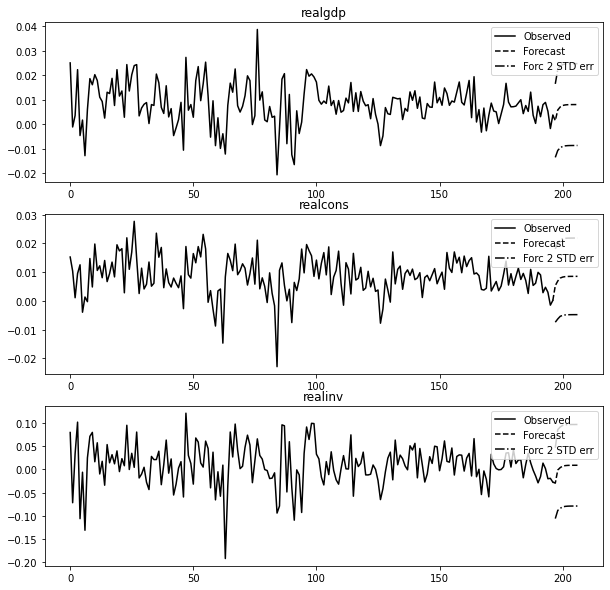

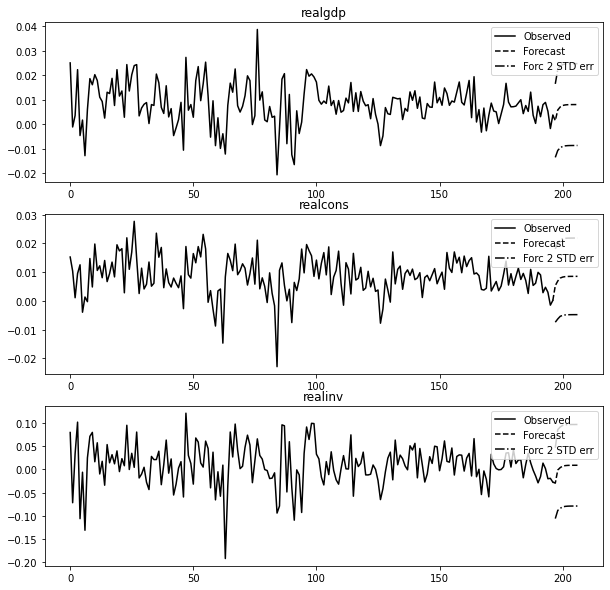

In [121]:
model_fit.plot_forecast(10)

In [122]:
pred = model_fit.forecast(X_train.values[-lag_order:], steps=obs)
pred = pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred')
pred

,realgdp_pred,realcons_pred,realinv_pred
2008-09-30,0.001401,0.005313,-0.029665
2008-12-31,0.005735,0.006914,-0.001235
2009-03-31,0.006979,0.007945,0.004034
2009-06-30,0.007575,0.008294,0.007256
2009-09-30,0.007798,0.008447,0.008359


In [123]:
# VAR Forecast evaluation

In [124]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [125]:
#Calculate forecast bias
forecast_errors = [X_test['realgdp'][i]- pred['realgdp_pred'][i] for i in range(len(X_test['realgdp']))]
bias = sum(forecast_errors) * 1.0/len(X_test['realgdp'])
print('Bias: %f' % bias)

#Calculate mean absolute error
mae = mean_absolute_error(X_test['realgdp'],pred['realgdp_pred'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['realgdp'], pred['realgdp_pred'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -0.012335
MAE: 0.012335
MSE: 0.000219
RMSE: 0.014799


### 벡터오차수정모형(Vector Autocorection Model, VECM)

- 공적분 관계의 존재 여부에 따라 VAR와 VECM을 선택
- 공적분(Cointegration): 두 비정상 시계열을 선형조합 했을 때 시계열의 적분 차수가 낮아지거나 정상상태가 되는 경우
   * 적분차수: 정상성이 되기까지 차분해야 하는 횟수
- 두 개 이상의 시계열이 공적분 관계에 있으면 장기관계 또는 균형관계를 가진다는 의미
  - VAR 모형은 각 시계열이 안정성 조건을 만족하지 않아도 사용할 수 있지만, 일반적으로 불안정성 시계열의 경우 차분을 하거나 변수간 장기적 관계에 대하여 정보를 상실할 수 있다는 단점
  - 따라서 변수간 공적분 관계에 있는 시계열은 차분을 거치지 않고 원 데이터를 써서 모형에 적합시킬 수 있다는 점에서 장점을 가진다
  - "Spurious Correlation" (가짜 상관관계)

In [126]:
# VECM Estimation and Analysis

In [127]:
from statsmodels.tsa.vector_ar import vecm

In [128]:
## Statistical Test for Cointegration (VECM 공적분 테스트)
## 귀무가설 : 공적분 특성없다, 대립가설 : 공적분 특성 있다

In [129]:
vec_rank = vecm.select_coint_rank(X_train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          221.1          41.08
  1   3          109.7          23.15
  2   3          39.12          6.635
-------------------------------------


In [130]:
vec_rank2 = vecm.select_coint_rank(X_train, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          111.4          29.26
  1   2          70.58          21.75
  2   3          39.12          6.635
-------------------------------------


In [139]:
vecm = vecm.VECM(endog = X_train, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=10)

array([[ 0.00082687,  0.00010849, -0.00520949],
       [-0.00249132, -0.00304268, -0.02092717],
       [-0.00242262, -0.00120947, -0.03049337],
       [-0.00187847,  0.00074454, -0.02943497],
       [-0.00018527,  0.00233478, -0.02139283],
       [ 0.00200132,  0.00645151, -0.01665064],
       [ 0.00712903,  0.00793533,  0.01693045],
       [ 0.00686419,  0.00854292,  0.01681462],
       [ 0.01011226,  0.01106216,  0.02519952],
       [ 0.01133034,  0.01202314,  0.03487855]])

In [135]:
forecast, lower, upper = vecm_fit.predict(10, 0.05)
print('Lower Bounds of Confidence Intervals:')
print(lower.round(3))
print('\nPoint Forecasts:')
print(forecast.round(3))
print('\nUpper Bounds of Confidence Intervals:')
print(upper.round(3))

Lower Bounds of Confidence Intervals:
[[-0.012 -0.011 -0.068]
 [-0.016 -0.014 -0.089]
 [-0.017 -0.013 -0.1  ]
 [-0.016 -0.011 -0.099]
 [-0.015 -0.01  -0.094]
 [-0.013 -0.006 -0.091]
 [-0.008 -0.005 -0.059]
 [-0.009 -0.004 -0.06 ]
 [-0.006 -0.002 -0.054]
 [-0.005 -0.001 -0.046]]

Point Forecasts:
[[ 0.001  0.    -0.005]
 [-0.002 -0.003 -0.021]
 [-0.002 -0.001 -0.03 ]
 [-0.002  0.001 -0.029]
 [-0.     0.002 -0.021]
 [ 0.002  0.006 -0.017]
 [ 0.007  0.008  0.017]
 [ 0.007  0.009  0.017]
 [ 0.01   0.011  0.025]
 [ 0.011  0.012  0.035]]

Upper Bounds of Confidence Intervals:
[[0.014 0.011 0.057]
 [0.011 0.008 0.047]
 [0.012 0.01  0.039]
 [0.013 0.013 0.04 ]
 [0.015 0.015 0.051]
 [0.017 0.019 0.058]
 [0.023 0.021 0.092]
 [0.023 0.021 0.094]
 [0.026 0.024 0.105]
 [0.027 0.025 0.116]]


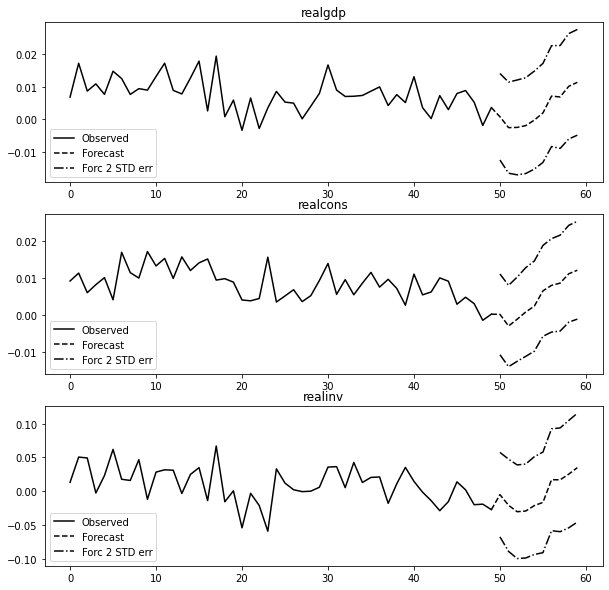

In [136]:
vecm_fit.plot_forecast(steps=10, n_last_obs=50)

In [ ]:
# Lag order selection

In [141]:
results = model_var.fit(maxlags=15, ic='aic')

In [142]:
model_var.select_order().summary() # default: 15

,AIC,BIC,FPE,HQIC
0,-27.84,-27.79,8.086e-13,-27.82
1,-28.11*,-27.90*,6.170e-13*,-28.03*
2,-28.10,-27.73,6.257e-13,-27.95
3,-28.11,-27.58,6.221e-13,-27.89
4,-28.09,-27.40,6.341e-13,-27.81
5,-28.09,-27.25,6.341e-13,-27.75
6,-28.03,-27.03,6.751e-13,-27.62
7,-27.98,-26.83,7.051e-13,-27.51
8,-28.00,-26.69,6.928e-13,-27.47
9,-28.01,-26.53,6.922e-13,-27.41


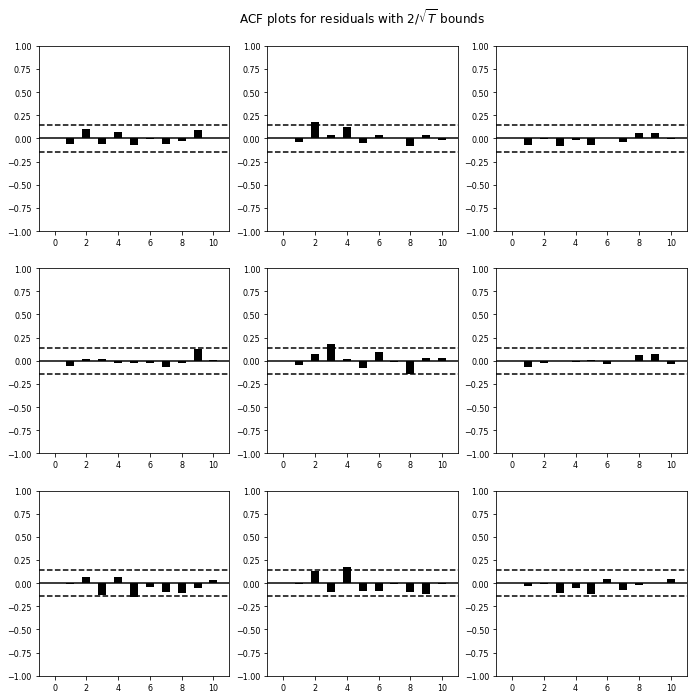

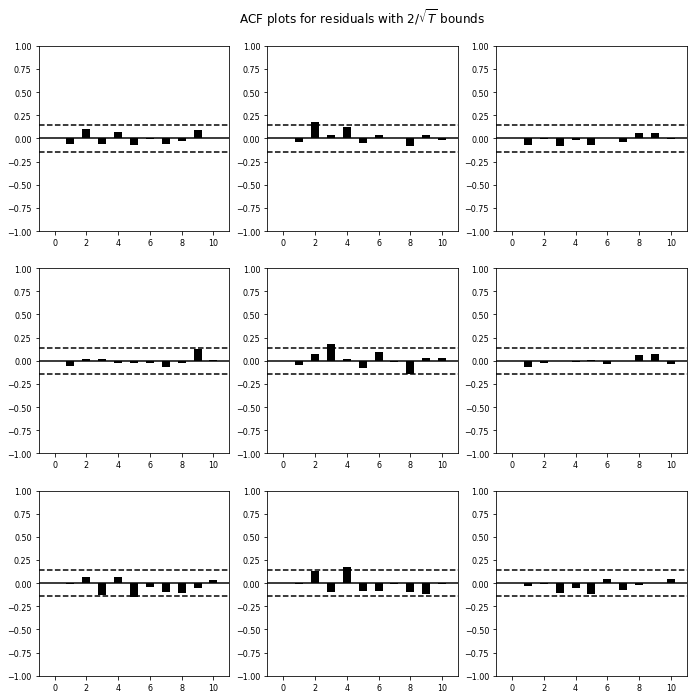

In [143]:
results.plot_acorr()

In [144]:
# Forecasting

In [145]:
lag_order = results.k_ar ## 위의 결과는?
results.forecast(data.values[-lag_order:], 5)

array([[0.00807494, 0.00871296, 0.00946954],
       [0.00804547, 0.00859197, 0.00970303],
       [0.00798359, 0.0085699 , 0.00929724],
       [0.00796638, 0.00855539, 0.00922561],
       [0.00795805, 0.00855054, 0.00918033]])

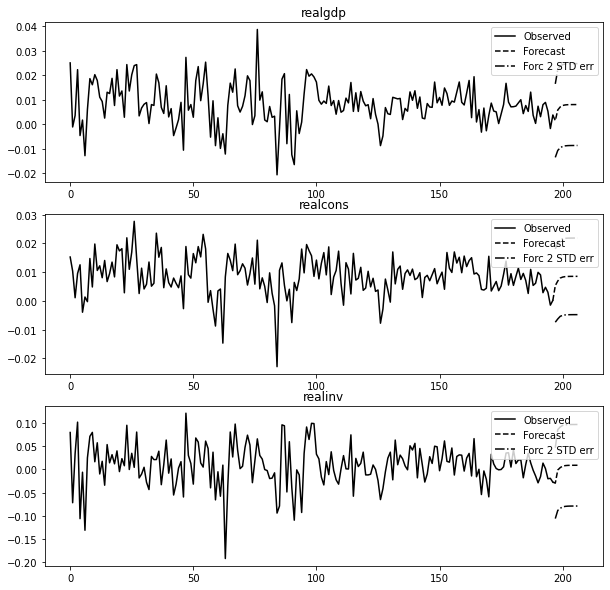

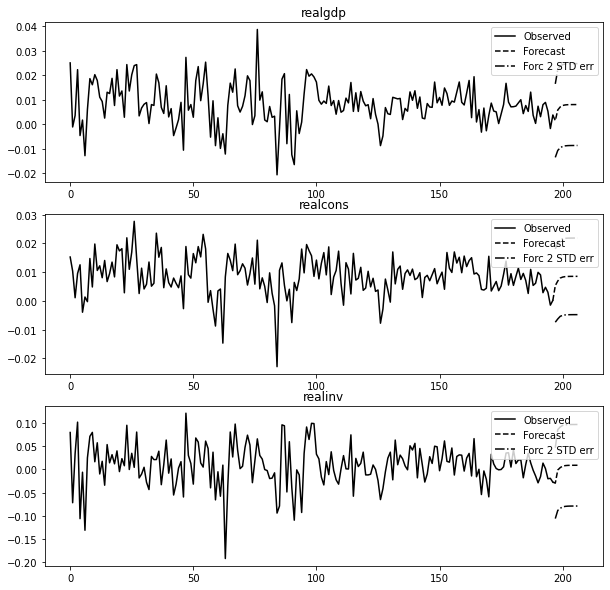

In [146]:
results.plot_forecast(10)

<b> 충격반응함수 </b>(Impulse Response Function, IRF)
- 충격반응함수는 VAR의 추정계수를 바탕으로 모형 내 변수에 대하여 일정한 크기의 충격을 가할 때 모형의 모든 변수들이 시간의 흐름에 따라 어떻게 반응하는가를 나타낸 것
- 내생변수의 현재값과 미래값에 대한 오차항 중 하나에 대한 1표준편차 충격(one standard deviation shock)의 효과를 추적함
- 즉, 특정 변수의 단위당 충격(unit shock)의 크기에 해당하는 충격을 그것이 자기 자신의 변수와 나머지 변수에 미치는 영향을 의미
- 변수간의 상호인과관계를 분석하고 변수의 변화에 따른 파급효과를 분석하는 데 이용




In [147]:
irf = results.irf(10)

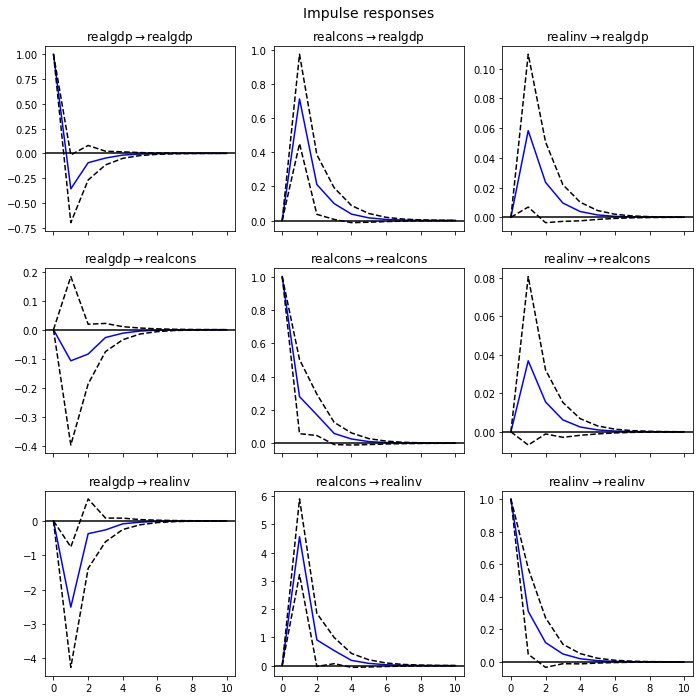

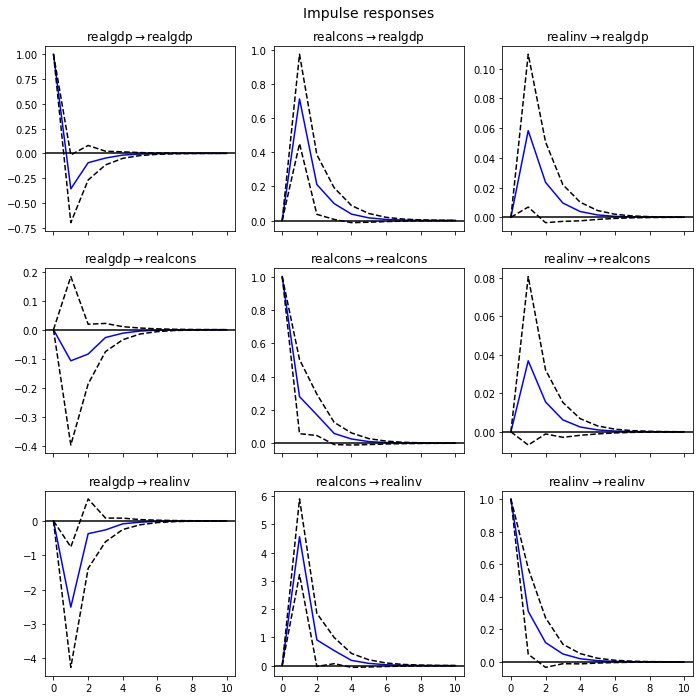

In [148]:
irf.plot(orth=False)

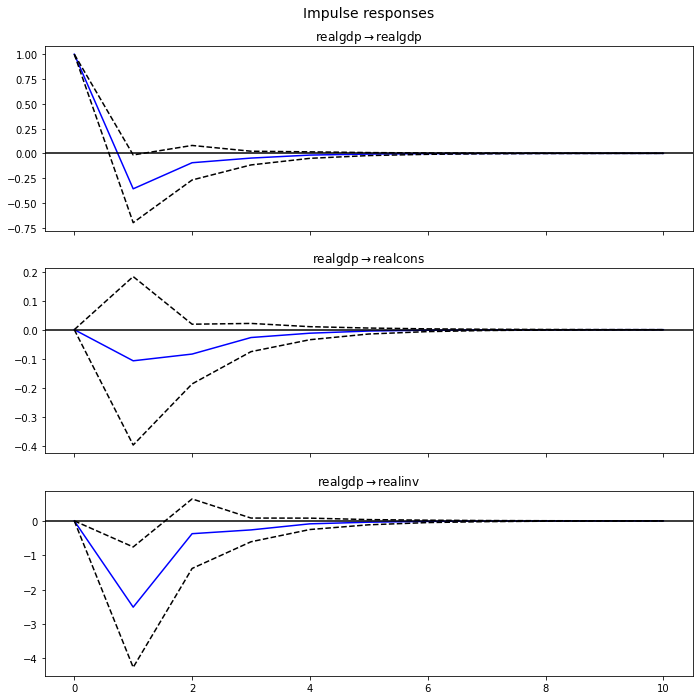

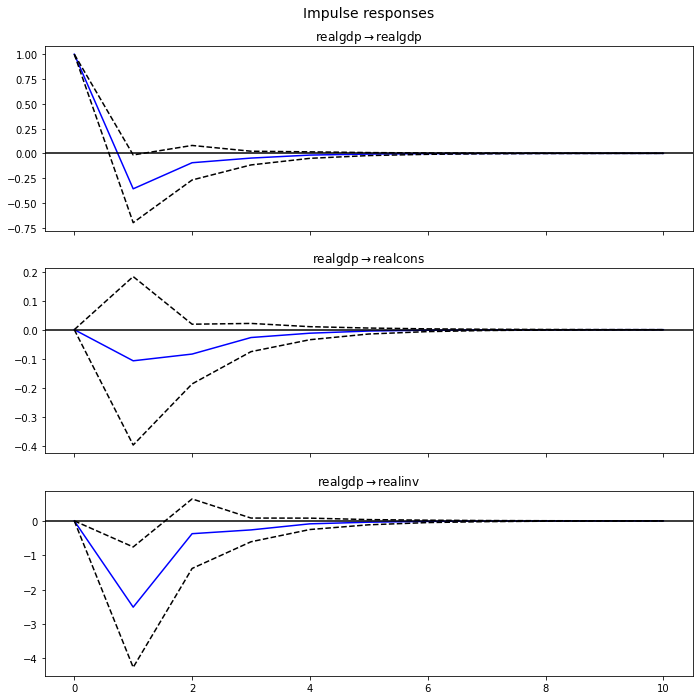

In [149]:
irf.plot(impulse='realgdp')

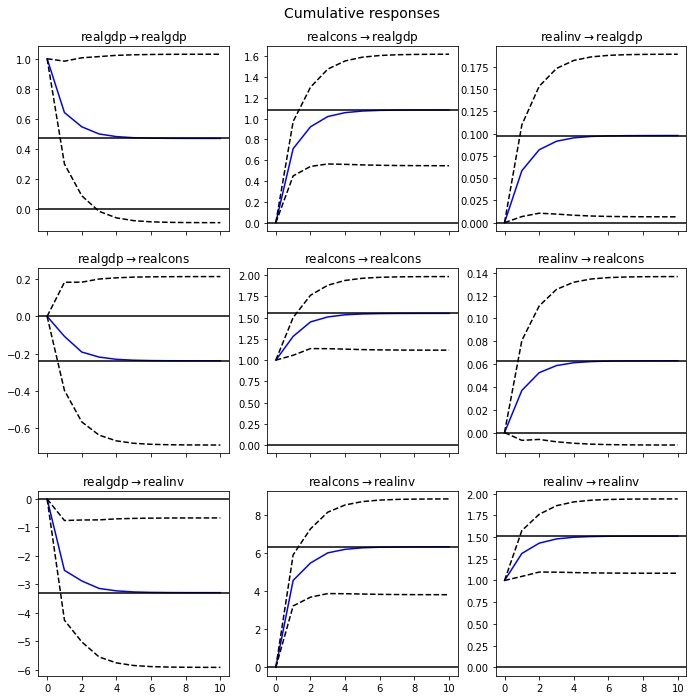

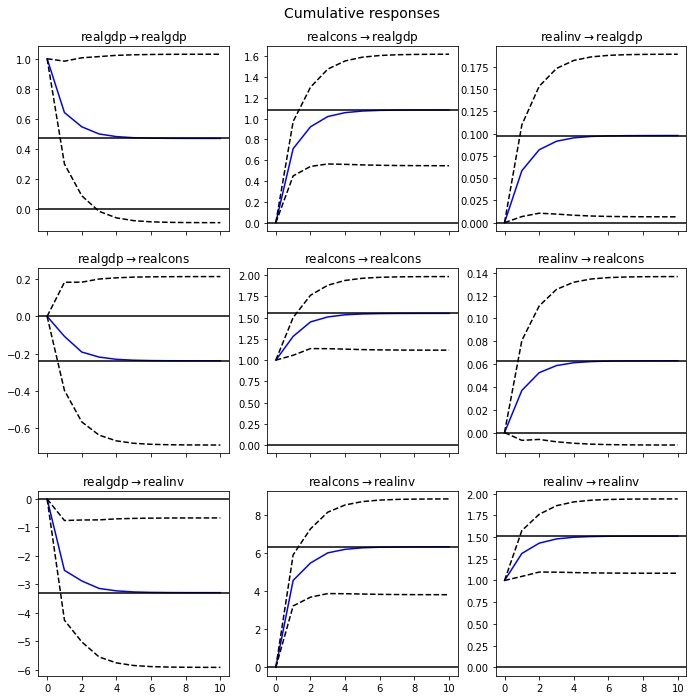

In [150]:
irf.plot_cum_effects(orth=False)

## <b> Ch 5. Part 4 요약 및 정리</b>

### 다변량 시계열의 예측

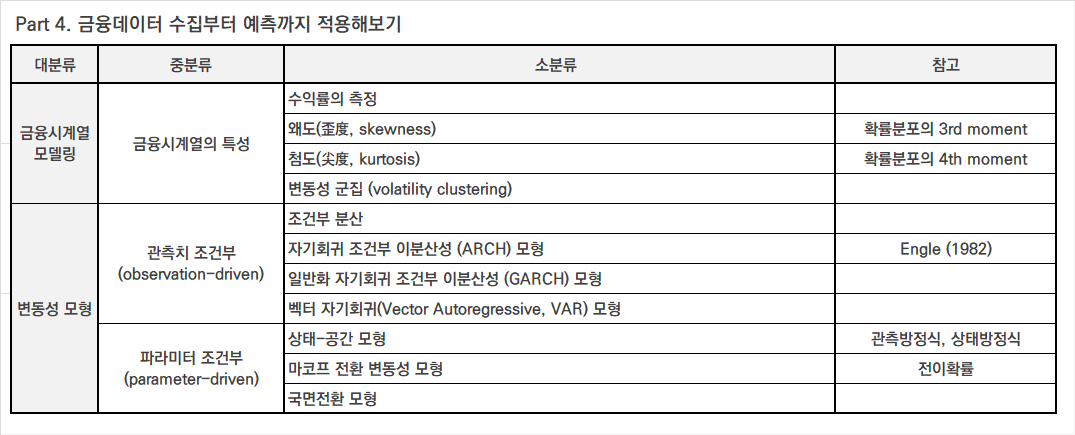

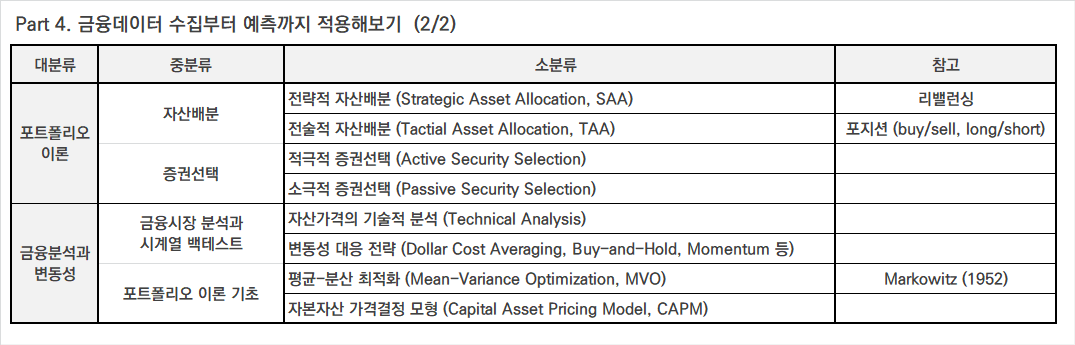

### 다음 파트: 딥러닝과 시계열

<b> 인공신경망</b> (Neural Network)
  - Multi-layered Perceptron (MLP), Retricted Boltzman Machines (RBM), Deep Belief Network(DBN)

<b> 딥러닝과 시계열</b> 
  - 아주 긴 시계열
  - 다변수 X, 다변수 y
  - 순환, 기억(memory)
  - t가 가변적인 경우
  - 숫자뿐 아니라 비정형 데이터
